# Gender Recoginition Task

__Prepare Dataset__

In [2]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models   

from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF      

from PIL import Image                               
import numpy as np
import os

In [50]:
data_dir = './img/face_gender'

from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), preprocess)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
print('Training dataset size:', len(train_datasets))

val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

Training dataset size: 47009
Validation dataset size: 11649
Class names: ['female', 'male']


__Prepare model__

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v2(weights=None)
num_classes = 2
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, num_classes)
)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

__Learning related functions__

In [116]:
# functions
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    loss_list = []
    batch = 0
    for images, labels in iter(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        model(images)
        outputs = model(images)
        loss = criterion(outputs, labels) 
        loss.backward()
        loss_list.append(loss.detach().cpu().numpy().item())   
        optimizer.step()
        if batch % 700 == 0:
            print(f"{batch=}, {loss=}")
        batch += 1
        # break
    return loss_list

def validate(model, val_dataloader, criterion, device):
    model.eval()
    loss_list = []
    test_error_count = 0
    for images, labels in iter(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.detach().cpu().numpy().item())
            test_error_count += float(torch.sum(torch.abs(labels -   
                                outputs.argmax(1))))  
        # break
    test_accuracy = 1.0 - float(test_error_count) / float(len(val_datasets))    
    print(f"accuracy {test_accuracy}")
    return loss_list, test_accuracy

__Learning__

In [119]:
NUM_EPOCHS = 6
train_losses = []
validation_losses = []
accuracies = []

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for epoch in range(NUM_EPOCHS):
    print(f"{epoch=}")
    print(f"learning rate: {optimizer.param_groups[0]['lr']}")
    train_loss = train(model, train_dataloader, optimizer, F.cross_entropy, device)
    val_loss, accuracy = validate(model, val_dataloader, F.cross_entropy, device)

    # record loss
    train_losses.extend(train_loss)
    validation_losses.extend(val_loss)
    accuracies.append(accuracy)

    scheduler.step()


epoch=0
learning rate: 0.01
batch=0, loss=tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=700, loss=tensor(0.2919, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=1400, loss=tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=2100, loss=tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=2800, loss=tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward0>)
accuracy 0.947119924457035
epoch=1
learning rate: 0.01
batch=0, loss=tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=700, loss=tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=1400, loss=tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=2100, loss=tensor(0.1423, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=2800, loss=tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward0>)
accuracy 0.959910721950382
epoch=2
learning rate: 0.001
batch=0, loss=tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward0>)
batch=700, loss=tensor(0.

In [ ]:
# save weights
model_weights = model.state_dict()
weights_path = 'model_weights.pth'
torch.save(model_weights, weights_path)

__Plot Result__

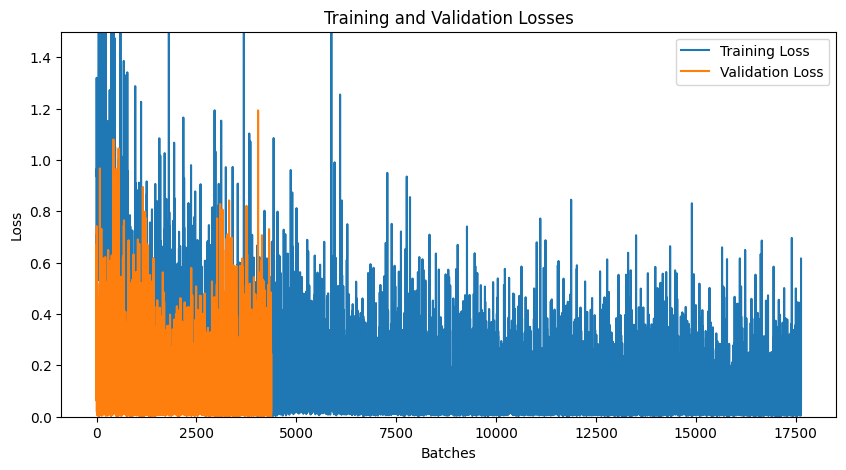

In [125]:
from matplotlib import pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

time = range(len(train_losses))

# loss plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.show()

# accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1.4664250612258911